### Instalação Biblioteca

In [1]:
# Instalar bibliotecas ( necessário)
!pip install mlflow evidently scikit-learn pandas numpy matplotlib seaborn papermill

# Importar pacotes principais
import pandas as pd
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from evidently.report import Report
from evidently.metrics import DataDriftTable
import pickle



[notice] A new release of pip available: 22.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Configurar MLflow para rastreamento de experimentos com objetivo de monitorar todo o processo, incluindo tempo de carregamento, transformações e qualidade dos dados. início do pipeline.

In [2]:
import mlflow
import os

# Definindo um novo diretório para armazenar os logs dos experimentos
caminho_logs = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Aplicando_para_dissertacao/mlflow_logs"

# Criar o diretório se não existir
os.makedirs(caminho_logs, exist_ok=True)

# Convertendo o caminho para o formato correto de URI
caminho_logs_uri = f"file:///{os.path.abspath(caminho_logs)}"

# Configurando o MLflow para usar esse diretório
mlflow.set_tracking_uri(caminho_logs_uri)

# Criando ou definindo o experimento
mlflow.set_experiment("Evasao_UFCG")

# Exibir a configuração para garantir que está correto
print(f"Tracking URI: {mlflow.get_tracking_uri()}")


Tracking URI: file:///E:\Mestrado UFCG\Semestre 2024.2\Dados\Aplicando_para_dissertacao\mlflow_logs


### Carregar os dados as tabelas relevantes

In [3]:
import pandas as pd
import os
import mlflow

# Definindo caminhos
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"
tables = ["alunos", "matriculas"]

# Iniciar Experimento MLflow
mlflow.set_experiment("Carregamento de Dados UFCG")

with mlflow.start_run():
    # Log do início do carregamento usando métrica em vez de parâmetro fixo
    mlflow.log_metric("status_iniciando", 1)

    dados = {}
    
    for table in tables:
        caminho = os.path.join(caminho_base, f"{table}.csv")
        try:
            # Detectar delimitador correto
            with open(caminho, "r", encoding="utf-8") as f:
                primeira_linha = f.readline()
                if ";" in primeira_linha:
                    delimitador = ";"
                elif "," in primeira_linha:
                    delimitador = ","
                elif "\t" in primeira_linha:
                    delimitador = "\t"
                else:
                    delimitador = ","  # Padrão caso não detecte

            # Carregar CSV com delimitador correto
            df = pd.read_csv(caminho, delimiter=delimitador, encoding="utf-8")
            
            # Verifica se carregou corretamente
            if df.shape[1] == 1:
                print(f" Atenção: {table} foi carregada com apenas 1 coluna! Pode haver erro no delimitador.")
            
            dados[table] = df
            print(f"{table} carregada com sucesso! ({df.shape[0]} linhas, {df.shape[1]} colunas)")
        except Exception as e:
            print(f"Erro ao carregar {table}: {e}")
            mlflow.log_param(f"erro_{table}", str(e))  # Log do erro no MLflow

    # Usar métrica ao invés de parâmetro para evitar erro no MLflow
    mlflow.log_metric("status_carregamento_finalizado", 1)

    print(" Carregamento finalizado.")


alunos carregada com sucesso! (3761 linhas, 22 colunas)
matriculas carregada com sucesso! (182660 linhas, 10 colunas)
 Carregamento finalizado.


### Visualizar colunas das tabelas

In [4]:
import pandas as pd

# Caminho base onde as tabelas estão armazenadas
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"

# Lista com os nomes das tabelas
tables = ["alunos", "matriculas"]

# Carregar e exibir as colunas de cada tabela
for tabela in tables:
    # Carregar a tabela especificando o separador ';'
    tabela_df = pd.read_csv(caminho_base + tabela + ".csv", sep=';', on_bad_lines='skip')
    
    # Mostrar as primeiras linhas e as colunas da tabela
    print(f"\nColunas da tabela '{tabela}':")
    print(tabela_df.columns.tolist())


Colunas da tabela 'alunos':
['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'E-MAIL', 'GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'LOCAL_NASCIMENTO', 'ESTADO', 'TERMO_ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO', 'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR', ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS']

Colunas da tabela 'matriculas':
['MATRICULA', 'CODIGO_DISCIPLINA', 'NOME', 'CREDITOS', 'HORAS', 'TERMO', 'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO']


### Filtro de Intervalo da pesquisa: 2001.1 - 2023.2

In [5]:
import pandas as pd

# Caminho base onde as tabelas estão armazenadas
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"

# Lista com os nomes das tabelas
tables = ["alunos", "matriculas"]

# Carregar e exibir as colunas de cada tabela
for tabela in tables:
    # Carregar a tabela especificando o separador ';'
    tabela_df = pd.read_csv(caminho_base + tabela + ".csv", sep=';', on_bad_lines='skip')
    
    # Mostrar as primeiras linhas e as colunas da tabela
    print(f"\nColunas da tabela '{tabela}':")
    print(tabela_df.columns.tolist())
    
    # Se a tabela for "matriculas", aplicar o filtro de ano e semestre
    if tabela == "matriculas":
        # Garantir que a coluna 'TERMO' esteja em formato adequado (se necessário)
        tabela_df['TERMO'] = tabela_df['TERMO'].astype(str)
        
        # Filtrar os registros entre 2002.1 e 2023.2
        tabela_df = tabela_df[tabela_df['TERMO'].between('2002.1', '2023.2')]
        
        # Exibir as primeiras linhas após o filtro
        print(f"\nPrimeiras linhas da tabela '{tabela}' após o filtro:")
        print(tabela_df.head())



Colunas da tabela 'alunos':
['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'E-MAIL', 'GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'LOCAL_NASCIMENTO', 'ESTADO', 'TERMO_ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO', 'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR', ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS']

Colunas da tabela 'matriculas':
['MATRICULA', 'CODIGO_DISCIPLINA', 'NOME', 'CREDITOS', 'HORAS', 'TERMO', 'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO']

Primeiras linhas da tabela 'matriculas' após o filtro:
       MATRICULA  CODIGO_DISCIPLINA                                     NOME  \
25990  194110044            1411170                        TEORIA DOS GRAFOS   
25991  194110044            1411172         ESTRUTURAS DE DADOS E ALGORITMOS   
25992  194110044            1411179  LAB.DE ESTRUTURAS DE DADOS E ALGORITMOS   
25993  194110044            1411192                    SISTEMAS OPERACIONAIS   
29

In [6]:
import pandas as pd

# Caminho base onde as tabelas estão armazenadas
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"

# Lista com os nomes das tabelas
tables = ["alunos", "matriculas"]

# Carregar e exibir as colunas de cada tabela
for tabela in tables:
    # Carregar a tabela especificando o separador ';'
    tabela_df = pd.read_csv(caminho_base + tabela + ".csv", sep=';', on_bad_lines='skip')
    
    # Se a tabela for "matriculas", aplicar o filtro de ano e semestre
    if tabela == "matriculas":
        # Garantir que a coluna 'TERMO' esteja em formato adequado (se necessário)
        tabela_df['TERMO'] = tabela_df['TERMO'].astype(str)
        
        # Filtrar os registros entre 2002.1 e 2023.2
        tabela_df = tabela_df[tabela_df['TERMO'].between('2002.1', '2023.2')]
    
    # Mostrar as dimensões (linhas e colunas) da tabela
    print(f"\nTabela '{tabela}' tem {tabela_df.shape[0]} linhas e {tabela_df.shape[1]} colunas.")



Tabela 'alunos' tem 3761 linhas e 22 colunas.

Tabela 'matriculas' tem 136066 linhas e 10 colunas.


### Remover dados duplicados ou não relacionados

In [7]:
import pandas as pd

# Caminho base onde as tabelas estão armazenadas
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"

# Lista com os nomes das tabelas
tables = ["alunos", "matriculas"]

# Carregar e exibir as colunas de cada tabela
for tabela in tables:
    # Carregar a tabela especificando o separador ';'
    tabela_df = pd.read_csv(caminho_base + tabela + ".csv", sep=';', on_bad_lines='skip')
    
    # Se a tabela for "matriculas", aplicar o filtro de ano e semestre
    if tabela == "matriculas":
        # Garantir que a coluna 'TERMO' esteja em formato adequado (se necessário)
        tabela_df['TERMO'] = tabela_df['TERMO'].astype(str)
        
        # Filtrar os registros entre 2002.1 e 2023.2
        tabela_df = tabela_df[tabela_df['TERMO'].between('2002.1', '2023.2')]
        
        # Remover duplicatas com base na coluna 'MATRICULA' (ou qualquer outra que identifique um aluno único)
        tabela_df = tabela_df.drop_duplicates(subset=['MATRICULA'], keep='first')  # Mantém a primeira ocorrência de cada matrícula
    
    # Mostrar as dimensões (linhas e colunas) da tabela após o tratamento
    print(f"\nTabela '{tabela}' tem {tabela_df.shape[0]} linhas e {tabela_df.shape[1]} colunas após tratamento de duplicação.")



Tabela 'alunos' tem 3761 linhas e 22 colunas após tratamento de duplicação.

Tabela 'matriculas' tem 3789 linhas e 10 colunas após tratamento de duplicação.


### A Identificar Colunas 

In [9]:
import pandas as pd
import os

# Caminho base onde as tabelas estão armazenadas
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"

# Lista com os nomes das tabelas
tables = ["alunos", "matriculas"]

# Verificar se o caminho da base existe
if not os.path.exists(caminho_base):
    print(f"❌ O diretório {caminho_base} não foi encontrado.")
else:
    # Iterar sobre cada tabela e carregar os dados
    for tabela in tables:
        caminho_arquivo = os.path.join(caminho_base, tabela + ".csv")

        if os.path.exists(caminho_arquivo):
            try:
                # Carregar a tabela especificando o separador ";"
                tabela_df = pd.read_csv(caminho_arquivo, sep=';', on_bad_lines='skip', encoding='utf-8')

                # Exibir o nome da tabela e suas colunas
                print(f"\n📂 Colunas da tabela: {tabela}")
                print(tabela_df.columns.tolist())

            except Exception as e:
                print(f"⚠️ Erro ao carregar a tabela {tabela}: {e}")

        else:
            print(f"❌ Arquivo não encontrado: {caminho_arquivo}")



📂 Colunas da tabela: alunos
['MATRICULA', 'ID_CIDADAO', 'NOME', 'IDADE', 'E-MAIL', 'GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'LOCAL_NASCIMENTO', 'ESTADO', 'TERMO_ESTADO', 'RAZAO_INATIVIDADE', 'TIPO_ADMISSAO', 'TERMO_ADMISSAO', 'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'CODIGO_CURRICULAR', ' ALUNOS_ATIVOS', 'EX_ALUNOS', 'ALUNOS_INATIVOS']

📂 Colunas da tabela: matriculas
['MATRICULA', 'CODIGO_DISCIPLINA', 'NOME', 'CREDITOS', 'HORAS', 'TERMO', 'ID_CLASS', 'NOTA', 'ESTATUS', 'TIPO']


### Realizar Junção das duas tabelas

In [14]:
import pandas as pd

# Caminho base onde as tabelas estão armazenadas
caminho_base = "E:/Mestrado UFCG/Semestre 2024.2/Dados/Tabelas_0/"

# Nomes das tabelas
tables = ["alunos", "matriculas"]

# Carregar as tabelas
alunos_df = pd.read_csv(caminho_base + "alunos.csv", sep=';', on_bad_lines='skip')
matriculas_df = pd.read_csv(caminho_base + "matriculas.csv", sep=';', on_bad_lines='skip')

# Realizar o merge das duas tabelas com base na coluna 'MATRICULA'
merged_df = pd.merge(alunos_df, matriculas_df, on='MATRICULA', suffixes=('_alunos', '_matriculas'))

# Comparar a coluna 'NOME' nas duas tabelas
merged_df['NOME_iguais'] = merged_df['NOME_alunos'] == merged_df['NOME_matriculas']

# Se os nomes forem iguais, remover a coluna 'NOME_matriculas'
merged_df = merged_df[~merged_df['NOME_iguais']].drop(columns=['NOME_matriculas', 'NOME_iguais'])

# Exibir o resultado final
print("Tabela final após o merge e remoção de NOME duplicado:")
print(merged_df.head())


Tabela final após o merge e remoção de NOME duplicado:
   MATRICULA    ID_CIDADAO                NOME_alunos  IDADE E-MAIL  \
0  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
1  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
2  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
3  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
4  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   

      GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE LOCAL_NASCIMENTO    ESTADO  \
0  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
1  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
2  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
3  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
4  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   

   ...  EX_ALUNOS ALUNOS_INATIVOS CODIGO_DISCIPLINA  CR

In [15]:
# Renomear a coluna 'NOME_alunos' para 'NOME'
merged_df = merged_df.rename(columns={'NOME_alunos': 'NOME'})

# Visualizar o número de linhas e colunas
num_linhas, num_colunas = merged_df.shape

# Exibir as informações
print(f"A tabela resultante possui {num_linhas} linhas e {num_colunas} colunas.")
print("Primeiras 5 linhas da tabela:")
print(merged_df.head())


A tabela resultante possui 130559 linhas e 30 colunas.
Primeiras 5 linhas da tabela:
   MATRICULA    ID_CIDADAO                       NOME  IDADE E-MAIL  \
0  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
1  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
2  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
3  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   
4  102210002  5.175670e+09  ELISMAEL GUIMARAES MENINO     43    NaN   

      GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE LOCAL_NASCIMENTO    ESTADO  \
0  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
1  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
2  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
3  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   
4  MASCULINO            SOLTEIRO    BRASILEIRA      PIANC? - PB  GRADUADO   

   ...  EX_ALUNOS ALUNOS_

In [16]:
# Remover duplicatas baseadas na coluna 'MATRICULA' ou em todas as colunas
merged_df = merged_df.drop_duplicates(subset='MATRICULA', keep='first')

# Ou, se preferir remover todas as duplicatas baseadas em todas as colunas:
# merged_df = merged_df.drop_duplicates(keep='first')

# Visualizar o número de linhas e colunas após a remoção das duplicatas
num_linhas, num_colunas = merged_df.shape

# Exibir as informações
print(f"A tabela resultante possui {num_linhas} linhas e {num_colunas} colunas após remoção de duplicatas.")
print("Primeiras 5 linhas da tabela:")
print(merged_df.head())


A tabela resultante possui 3508 linhas e 30 colunas após remoção de duplicatas.
Primeiras 5 linhas da tabela:
     MATRICULA    ID_CIDADAO                             NOME  IDADE E-MAIL  \
0    102210002  5.175670e+09        ELISMAEL GUIMARAES MENINO     43    NaN   
90   102210003           NaN      EDUARDO JOSE MOREIRA COLACO     40    NaN   
119  102210004  2.454245e+08  ADILTON ANGELO SEIXAS MAGALHAES     43    NaN   
175  102210005  1.195394e+09        RICARDO MADEIRA FERNANDES     43    NaN   
235  102210006  4.220965e+09            BRUNO COITINHO ARAUJO     40    NaN   

        GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE     LOCAL_NASCIMENTO  \
0    MASCULINO            SOLTEIRO    BRASILEIRA          PIANC? - PB   
90   MASCULINO            SOLTEIRO    BRASILEIRA  CAMPINA GRANDE - PB   
119  MASCULINO            SOLTEIRO    BRASILEIRA                  NaN   
175  MASCULINO            SOLTEIRO    BRASILEIRA       BOA VISTA - RR   
235  MASCULINO            SOLTEIRO    BRASILEIRA  

### Vamos visualizar colunas com valores ausentes 

In [17]:
import pandas as pd

# Verificar colunas com valores ausentes em merged_df
colunas_ausentes = merged_df.columns[merged_df.isnull().any()]

if len(colunas_ausentes) > 0:
    print("\nColunas com valores ausentes em 'merged_df':")
    print(colunas_ausentes.tolist())
else:
    print("\n'merged_df' não contém colunas com valores ausentes.")



Colunas com valores ausentes em 'merged_df':
['ID_CIDADAO', 'E-MAIL', 'LOCAL_NASCIMENTO', 'TERMO_ESTADO', 'ANO_FORMATURA_ENSINO_MEDIO', 'ID_CLASS']


In [18]:
# Exibir tipos das colunas com valores ausentes
print(merged_df[colunas_ausentes].dtypes)


ID_CIDADAO                    float64
E-MAIL                         object
LOCAL_NASCIMENTO               object
TERMO_ESTADO                  float64
ANO_FORMATURA_ENSINO_MEDIO    float64
ID_CLASS                      float64
dtype: object


In [19]:
# Tratamento dos valores ausentes
merged_df['ID_CIDADAO'].fillna(-1, inplace=True)
merged_df['E-MAIL'].fillna("Não informado", inplace=True)
merged_df['LOCAL_NASCIMENTO'].fillna("Desconhecido", inplace=True)
merged_df['TERMO_ESTADO'].fillna(merged_df['TERMO_ESTADO'].mode()[0], inplace=True)  # Preenche com a moda
merged_df['ANO_FORMATURA_ENSINO_MEDIO'].fillna(merged_df['ANO_FORMATURA_ENSINO_MEDIO'].median(), inplace=True)
merged_df['ID_CLASS'].fillna(-1, inplace=True)

# Verificar se ainda existem valores ausentes
print(merged_df[colunas_ausentes].isnull().sum())


ID_CIDADAO                    0
E-MAIL                        0
LOCAL_NASCIMENTO              0
TERMO_ESTADO                  0
ANO_FORMATURA_ENSINO_MEDIO    0
ID_CLASS                      0
dtype: int64


C:\Users\Big Data\AppData\Local\Temp\ipykernel_17856\3053659683.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['ID_CIDADAO'].fillna(-1, inplace=True)
C:\Users\Big Data\AppData\Local\Temp\ipykernel_17856\3053659683.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

F

### Conferir a base

In [20]:
print(merged_df.isnull().sum().sum())  # Deve retornar 0 se tudo estiver tratado


0


In [21]:
print(merged_df.head())


     MATRICULA    ID_CIDADAO                             NOME  IDADE  \
0    102210002  5.175670e+09        ELISMAEL GUIMARAES MENINO     43   
90   102210003 -1.000000e+00      EDUARDO JOSE MOREIRA COLACO     40   
119  102210004  2.454245e+08  ADILTON ANGELO SEIXAS MAGALHAES     43   
175  102210005  1.195394e+09        RICARDO MADEIRA FERNANDES     43   
235  102210006  4.220965e+09            BRUNO COITINHO ARAUJO     40   

            E-MAIL     GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE  \
0    Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
90   Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
119  Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
175  Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
235  Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   

        LOCAL_NASCIMENTO    ESTADO  ...  EX_ALUNOS ALUNOS_INATIVOS  \
0            PIANC? - PB  GRADUADO  ...       True           False   
90   CAMPINA GRANDE - PB

In [22]:
pd.set_option('display.max_columns', None)  # Garante que todas as colunas sejam exibidas
print(merged_df.head())


     MATRICULA    ID_CIDADAO                             NOME  IDADE  \
0    102210002  5.175670e+09        ELISMAEL GUIMARAES MENINO     43   
90   102210003 -1.000000e+00      EDUARDO JOSE MOREIRA COLACO     40   
119  102210004  2.454245e+08  ADILTON ANGELO SEIXAS MAGALHAES     43   
175  102210005  1.195394e+09        RICARDO MADEIRA FERNANDES     43   
235  102210006  4.220965e+09            BRUNO COITINHO ARAUJO     40   

            E-MAIL     GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE  \
0    Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
90   Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
119  Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
175  Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   
235  Não informado  MASCULINO            SOLTEIRO    BRASILEIRA   

        LOCAL_NASCIMENTO    ESTADO  TERMO_ESTADO RAZAO_INATIVIDADE  \
0            PIANC? - PB  GRADUADO        2009.1      DESCONHECIDO   
90   CAMPINA GRANDE - PB

### Seleção colunas relevantes

In [26]:
# Definição das colunas relevantes
colunas_relevantes = [
    'IDADE', 'GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'TIPO_ADMISSAO',
    'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO', 'ANO_FORMATURA_ENSINO_MEDIO',
    'CODIGO_CURSO', 'TERMO_ESTADO', 'CREDITOS', 'HORAS', 'NOTA', 'ESTATUS', 'ESTADO'
]

# Criar novo DataFrame apenas com as colunas selecionadas
df_modelo = merged_df[colunas_relevantes].copy()

# Exibir as 5 primeiras linhas para conferir
print(df_modelo.head())


     IDADE     GENERO ESTADO_CIVIL_ALUNOS NACIONALIDADE TIPO_ADMISSAO  \
0       43  MASCULINO            SOLTEIRO    BRASILEIRA    VESTIBULAR   
90      40  MASCULINO            SOLTEIRO    BRASILEIRA    VESTIBULAR   
119     43  MASCULINO            SOLTEIRO    BRASILEIRA    VESTIBULAR   
175     43  MASCULINO            SOLTEIRO    BRASILEIRA    VESTIBULAR   
235     40  MASCULINO            SOLTEIRO    BRASILEIRA    VESTIBULAR   

    POLITICA_AFIRMATIVA TIPO_ENSINO_MEDIO  ANO_FORMATURA_ENSINO_MEDIO  \
0                    A0      DESCONHECIDA                      2014.0   
90                   A0      DESCONHECIDA                      2014.0   
119                  A0      DESCONHECIDA                      2014.0   
175                  A0      DESCONHECIDA                      2014.0   
235                  A0      DESCONHECIDA                      2014.0   

     CODIGO_CURSO  TERMO_ESTADO  CREDITOS  HORAS  NOTA   ESTATUS    ESTADO  
0        14102100        2009.1         4    

In [27]:
df_modelo.dtypes


IDADE                           int64
GENERO                         object
ESTADO_CIVIL_ALUNOS            object
NACIONALIDADE                  object
TIPO_ADMISSAO                  object
POLITICA_AFIRMATIVA            object
TIPO_ENSINO_MEDIO              object
ANO_FORMATURA_ENSINO_MEDIO    float64
CODIGO_CURSO                    int64
TERMO_ESTADO                  float64
CREDITOS                        int64
HORAS                           int64
NOTA                          float64
ESTATUS                        object
ESTADO                         object
dtype: object

In [28]:
print(df_modelo.isnull().sum().sum())  # Deve retornar 0 se tudo estiver tratado


0


### verificar os valores únicos da variável ESTADO

In [29]:
df_modelo["ESTADO"].unique()


array(['GRADUADO', 'INATIVO', 'ATIVO'], dtype=object)

### Transformação de Variáveis Categóricas

In [30]:
# Remover alunos que se formaram
df_modelo = df_modelo[df_modelo["ESTADO"] != "GRADUADO"]

# Criar a variável EVASAO
df_modelo["EVASAO"] = df_modelo["ESTADO"].apply(lambda x: 1 if x in ["INATIVO", "CANCELADO"] else 0)

# Verificar distribuição da variável EVASAO
print(df_modelo["EVASAO"].value_counts())


EVASAO
1    1709
0     726
Name: count, dtype: int64


In [ ]:
# Transformação das variáveis categóricas usando one-hot encoding
colunas_categoricas = ['GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'TIPO_ADMISSAO', 
                       'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO']
df_modelo = pd.get_dummies(df_modelo, columns=colunas_categoricas, drop_first=True)

# Exibir as primeiras linhas do dataframe transformado
print(df_modelo.head())

In [31]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder

# Listando as variáveis categóricas e numéricas
categorical_features = ['GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'TIPO_ADMISSAO', 
                        'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO', 'ESTATUS', 'ESTADO']
numerical_features = ['IDADE', 'ANO_FORMATURA_ENSINO_MEDIO', 'CODIGO_CURSO', 'TERMO_ESTADO', 
                      'CREDITOS', 'HORAS', 'NOTA']

# Criar um pipeline para as variáveis categóricas
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Criar um pipeline para as variáveis numéricas (padronização)
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Criar um pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Aplicar o pré-processamento aos dados
X = preprocessor.fit_transform(df_modelo)

# Visualizar o resultado do pré-processamento
print(X.shape)


(2435, 46)


In [32]:
# Visualizando as colunas resultantes
columns = preprocessor.get_feature_names_out()
print(columns)


['num__IDADE' 'num__ANO_FORMATURA_ENSINO_MEDIO' 'num__CODIGO_CURSO'
 'num__TERMO_ESTADO' 'num__CREDITOS' 'num__HORAS' 'num__NOTA'
 'cat__GENERO_FEMININO' 'cat__GENERO_MASCULINO'
 'cat__ESTADO_CIVIL_ALUNOS_CASADO' 'cat__ESTADO_CIVIL_ALUNOS_DESCONHECIDO'
 'cat__ESTADO_CIVIL_ALUNOS_DIVORCIADO' 'cat__ESTADO_CIVIL_ALUNOS_SOLTEIRO'
 'cat__ESTADO_CIVIL_ALUNOS_VIUVO' 'cat__NACIONALIDADE_BRASILEIRA'
 'cat__NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO'
 'cat__NACIONALIDADE_ESTRANGEIRA' 'cat__TIPO_ADMISSAO_CONVENIO'
 'cat__TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM' 'cat__TIPO_ADMISSAO_GRADUADO'
 'cat__TIPO_ADMISSAO_REOPCAO' 'cat__TIPO_ADMISSAO_SISU'
 'cat__TIPO_ADMISSAO_TRANSFERENCIA' 'cat__TIPO_ADMISSAO_VESTIBULAR'
 'cat__POLITICA_AFIRMATIVA_A0' 'cat__POLITICA_AFIRMATIVA_BONUS'
 'cat__POLITICA_AFIRMATIVA_L1' 'cat__POLITICA_AFIRMATIVA_L10'
 'cat__POLITICA_AFIRMATIVA_L13' 'cat__POLITICA_AFIRMATIVA_L14'
 'cat__POLITICA_AFIRMATIVA_L2' 'cat__POLITICA_AFIRMATIVA_L5'
 'cat__POLITICA_AFIRMATIVA_L6' 'cat__POLITIC

In [33]:
# Verificar as primeiras linhas da nova base
import pandas as pd

# Convertendo o array resultante em um DataFrame para visualização
df_transformed = pd.DataFrame(X, columns=columns)
print(df_transformed.head())


   num__IDADE  num__ANO_FORMATURA_ENSINO_MEDIO  num__CODIGO_CURSO  \
0    1.756239                        -0.132636                0.0   
1    2.066959                        -0.132636                0.0   
2    2.222319                        -0.132636                0.0   
3    1.911599                        -0.132636                0.0   
4    1.756239                        -0.132636                0.0   

   num__TERMO_ESTADO  num__CREDITOS  num__HORAS  num__NOTA  \
0          -2.700396       0.039374    0.039374  -1.515207   
1          -2.439828       0.039374    0.039374  -1.250284   
2          -1.892635       0.039374    0.039374  -1.250284   
3          -2.439828       0.039374    0.039374   0.657161   
4          -2.153203       0.039374    0.039374  -0.905884   

   cat__GENERO_FEMININO  cat__GENERO_MASCULINO  \
0                   0.0                    1.0   
1                   0.0                    1.0   
2                   0.0                    1.0   
3           

In [34]:
# Verificar o intervalo de anos na variável 'ANO_FORMATURA_ENSINO_MEDIO'
intervalo_anos = df_modelo['ANO_FORMATURA_ENSINO_MEDIO']

# Exibir o valor mínimo e máximo dessa variável
ano_minimo = intervalo_anos.min()
ano_maximo = intervalo_anos.max()

print(f'O intervalo de anos na variável ANO_FORMATURA_ENSINO_MEDIO é de {ano_minimo} a {ano_maximo}.')


O intervalo de anos na variável ANO_FORMATURA_ENSINO_MEDIO é de 1982.0 a 2023.0.


### Criação da Feature Store

### Passos para criação da Feature Store
1. Criar um DataFrame a partir dos dados transformados

In [36]:
import joblib

# Criar nomes de colunas após a transformação OneHotEncoder
cat_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
num_columns = numerical_features

# Unindo os nomes das colunas transformadas
columns_final = list(num_columns) + list(cat_columns)

# Criando o DataFrame final com os dados transformados
df_feature_store = pd.DataFrame(X, columns=columns_final)

# Salvando a Feature Store como CSV e Parquet
df_feature_store.to_csv("feature_store.csv", index=False)
df_feature_store.to_parquet("feature_store.parquet", index=False)

# Salvando o pré-processador para reutilização futura
joblib.dump(preprocessor, "preprocessor.pkl")

# Exibir as primeiras linhas
print(df_feature_store.head())


      IDADE  ANO_FORMATURA_ENSINO_MEDIO  CODIGO_CURSO  TERMO_ESTADO  CREDITOS  \
0  1.756239                   -0.132636           0.0     -2.700396  0.039374   
1  2.066959                   -0.132636           0.0     -2.439828  0.039374   
2  2.222319                   -0.132636           0.0     -1.892635  0.039374   
3  1.911599                   -0.132636           0.0     -2.439828  0.039374   
4  1.756239                   -0.132636           0.0     -2.153203  0.039374   

      HORAS      NOTA  GENERO_FEMININO  GENERO_MASCULINO  \
0  0.039374 -1.515207              0.0               1.0   
1  0.039374 -1.250284              0.0               1.0   
2  0.039374 -1.250284              0.0               1.0   
3  0.039374  0.657161              1.0               0.0   
4  0.039374 -0.905884              0.0               1.0   

   ESTADO_CIVIL_ALUNOS_CASADO  ESTADO_CIVIL_ALUNOS_DESCONHECIDO  \
0                         0.0                               0.0   
1                 

### Visualizar distribuição de dados

Visualização inicial dos dados:
      IDADE  ANO_FORMATURA_ENSINO_MEDIO  CODIGO_CURSO  TERMO_ESTADO  CREDITOS  \
0  1.756239                   -0.132636           0.0     -2.700396  0.039374   
1  2.066959                   -0.132636           0.0     -2.439828  0.039374   
2  2.222319                   -0.132636           0.0     -1.892635  0.039374   
3  1.911599                   -0.132636           0.0     -2.439828  0.039374   
4  1.756239                   -0.132636           0.0     -2.153203  0.039374   

      HORAS      NOTA  GENERO_FEMININO  GENERO_MASCULINO  \
0  0.039374 -1.515207              0.0               1.0   
1  0.039374 -1.250284              0.0               1.0   
2  0.039374 -1.250284              0.0               1.0   
3  0.039374  0.657161              1.0               0.0   
4  0.039374 -0.905884              0.0               1.0   

   ESTADO_CIVIL_ALUNOS_CASADO  ESTADO_CIVIL_ALUNOS_DESCONHECIDO  \
0                         0.0                        

C:\Users\Big Data\AppData\Local\Temp\ipykernel_17856\3064650515.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="coolwarm")


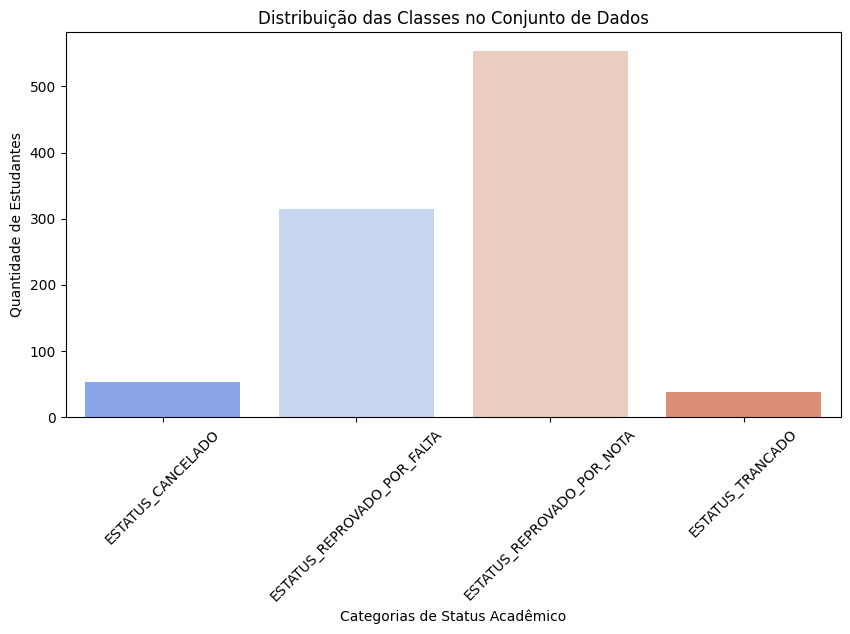

Estatísticas descritivas das variáveis numéricas:
              IDADE  ANO_FORMATURA_ENSINO_MEDIO  CODIGO_CURSO  TERMO_ESTADO  \
count  2.435000e+03                2.435000e+03        2435.0  2.435000e+03   
mean   1.867546e-16                1.867546e-15           0.0  3.128139e-15   
std    1.000205e+00                1.000205e+00           0.0  1.000205e+00   
min   -1.661683e+00               -7.004297e+00           0.0 -3.195476e+00   
25%   -8.848825e-01               -5.621146e-01           0.0 -5.897937e-01   
50%    4.727795e-02               -1.326358e-01           0.0 -9.471414e-02   
75%    6.687182e-01                7.263219e-01           0.0  4.264223e-01   
max    5.329520e+00                1.800019e+00           0.0  2.250400e+00   

           CREDITOS         HORAS          NOTA  GENERO_FEMININO  \
count  2.435000e+03  2.435000e+03  2.435000e+03      2435.000000   
mean  -1.103019e-15  5.164931e-16  9.337728e-17         0.180287   
std    1.000205e+00  1.000205e+00 

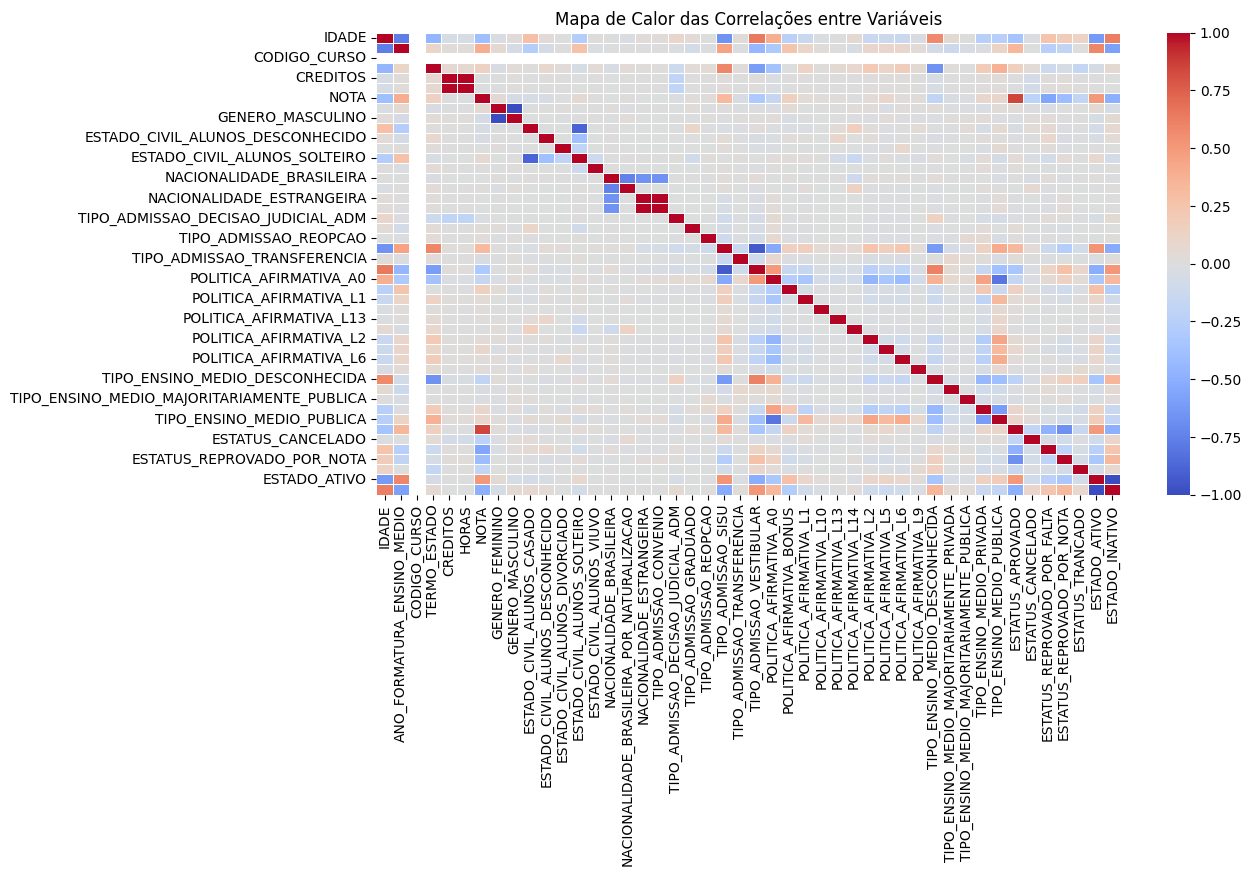

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar os dados transformados (Feature Store)
df_feature_store = pd.read_csv("feature_store.csv")

# Verificando as primeiras linhas do dataset
print("Visualização inicial dos dados:")
print(df_feature_store.head())

# Verificando a distribuição das classes
status_columns = ['ESTATUS_CANCELADO', 'ESTATUS_REPROVADO_POR_FALTA', 'ESTATUS_REPROVADO_POR_NOTA', 'ESTATUS_TRANCADO']

# Contagem das classes
class_distribution = df_feature_store[status_columns].sum()

# Plotando a distribuição das classes
plt.figure(figsize=(10, 5))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette="coolwarm")
plt.xlabel("Categorias de Status Acadêmico")
plt.ylabel("Quantidade de Estudantes")
plt.title("Distribuição das Classes no Conjunto de Dados")
plt.xticks(rotation=45)
plt.show()

# Estatísticas descritivas das variáveis numéricas
print("Estatísticas descritivas das variáveis numéricas:")
print(df_feature_store.describe())

# Verificar a correlação entre variáveis
plt.figure(figsize=(12, 6))
sns.heatmap(df_feature_store.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Mapa de Calor das Correlações entre Variáveis")
plt.show()


### Balanceamento da base

In [42]:
print("Colunas esperadas:", categorical_features)
print("Colunas transformadas:", preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))


Colunas esperadas: ['GENERO', 'ESTADO_CIVIL_ALUNOS', 'NACIONALIDADE', 'TIPO_ADMISSAO', 'POLITICA_AFIRMATIVA', 'TIPO_ENSINO_MEDIO', 'ESTATUS', 'ESTADO']
Colunas transformadas: ['GENERO_FEMININO' 'GENERO_MASCULINO' 'ESTADO_CIVIL_ALUNOS_CASADO'
 'ESTADO_CIVIL_ALUNOS_DESCONHECIDO' 'ESTADO_CIVIL_ALUNOS_DIVORCIADO'
 'ESTADO_CIVIL_ALUNOS_SOLTEIRO' 'ESTADO_CIVIL_ALUNOS_VIUVO'
 'NACIONALIDADE_BRASILEIRA' 'NACIONALIDADE_BRASILEIRA_POR_NATURALIZACAO'
 'NACIONALIDADE_ESTRANGEIRA' 'TIPO_ADMISSAO_CONVENIO'
 'TIPO_ADMISSAO_DECISAO_JUDICIAL_ADM' 'TIPO_ADMISSAO_GRADUADO'
 'TIPO_ADMISSAO_REOPCAO' 'TIPO_ADMISSAO_SISU'
 'TIPO_ADMISSAO_TRANSFERENCIA' 'TIPO_ADMISSAO_VESTIBULAR'
 'POLITICA_AFIRMATIVA_A0' 'POLITICA_AFIRMATIVA_BONUS'
 'POLITICA_AFIRMATIVA_L1' 'POLITICA_AFIRMATIVA_L10'
 'POLITICA_AFIRMATIVA_L13' 'POLITICA_AFIRMATIVA_L14'
 'POLITICA_AFIRMATIVA_L2' 'POLITICA_AFIRMATIVA_L5'
 'POLITICA_AFIRMATIVA_L6' 'POLITICA_AFIRMATIVA_L9'
 'TIPO_ENSINO_MEDIO_DESCONHECIDA'
 'TIPO_ENSINO_MEDIO_MAJORITARIAMENTE_PRI

In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(df_feature_store, y)

# Criar um novo DataFrame balanceado
df_balanced = pd.DataFrame(X_balanced, columns=columns_final)
df_balanced["Target"] = y_balanced

# Salvar os dados balanceados
df_balanced.to_csv("feature_store_balanced.csv", index=False)
df_balanced.to_parquet("feature_store_balanced.parquet", index=False)

# Exibir a nova distribuição da variável alvo
print("Dados balanceados! Nova distribuição das classes:")
print(df_balanced["Target"].value_counts())


Dados balanceados! Nova distribuição das classes:
Target
0.0    2382
1.0    2382
Name: count, dtype: int64


C:\Users\Big Data\AppData\Local\Temp\ipykernel_17856\1751178511.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="Blues")
C:\Users\Big Data\AppData\Local\Temp\ipykernel_17856\1751178511.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_balanced, palette="Oranges")


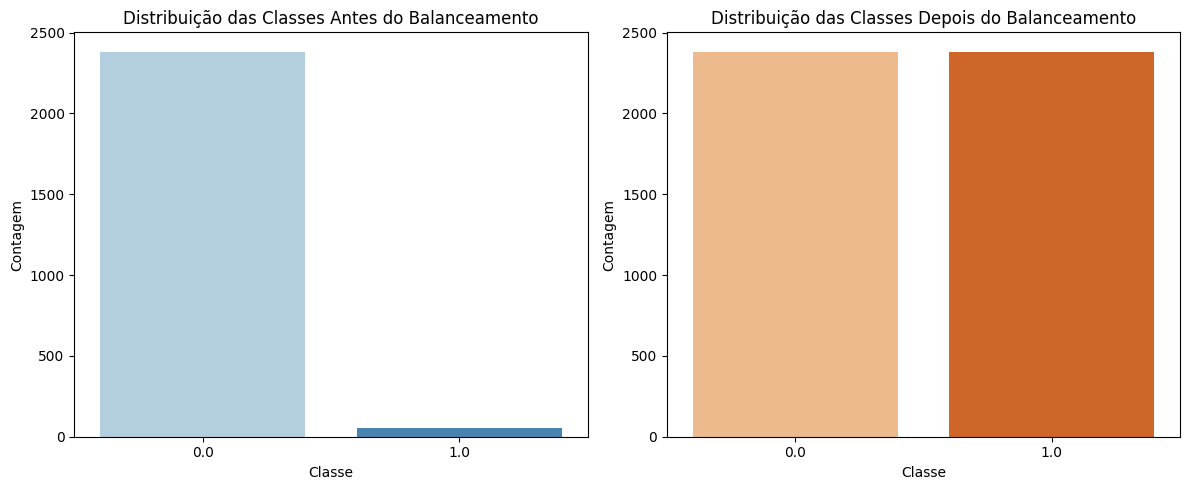

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualização antes do balanceamento
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.countplot(x=y, palette="Blues")
plt.title("Distribuição das Classes Antes do Balanceamento")
plt.xlabel("Classe")
plt.ylabel("Contagem")

# Visualização depois do balanceamento
plt.subplot(1, 2, 2)
sns.countplot(x=y_balanced, palette="Oranges")
plt.title("Distribuição das Classes Depois do Balanceamento")
plt.xlabel("Classe")
plt.ylabel("Contagem")

plt.tight_layout()
plt.show()


### Modelagem Preditiva

In [56]:
  import pandas as pd
  from sklearn.model_selection import train_test_split, cross_val_score
  from sklearn.preprocessing import StandardScaler
  from sklearn.linear_model import LogisticRegression
  from sklearn.neighbors import KNeighborsClassifier
  from sklearn.svm import SVC
  from sklearn.ensemble import AdaBoostClassifier
  from sklearn.metrics import accuracy_score


Carregue os dados balanceados:


In [57]:
df = pd.read_parquet("feature_store_balanced.parquet")


Separe as variáveis independentes (X) e a variável alvo (y):

In [58]:
X = df.drop(columns=["Target"])
y = df["Target"]

Divisão entre Conjunto de Treinamento e Teste:

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Inicialize os modelos:

In [60]:
models = {
    "Regressão Logística": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "AdaBoost": AdaBoostClassifier()
}


Configure o MLflow e registre os experimentos:

In [62]:
mlflow.set_experiment("Comparação de Modelos")

for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Treine o modelo
        model.fit(X_train, y_train)
        
        # Avalie o modelo com validação cruzada
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
        mean_accuracy = scores.mean()
        std_accuracy = scores.std()
        
        # Registre os parâmetros e métricas no MLflow
        mlflow.log_param("Modelo", name)
        mlflow.log_metric("Acurácia Média", mean_accuracy)
        mlflow.log_metric("Desvio Padrão da Acurácia", std_accuracy)
        
        # Registre o modelo treinado
        mlflow.sklearn.log_model(model, name)
        
        print(f"{name} - Acurácia média: {mean_accuracy:.4f} ± {std_accuracy:.4f}")


2025/03/31 17:14:34 INFO mlflow.tracking.fluent: Experiment with name 'Comparação de Modelos' does not exist. Creating a new experiment.
2025/03/31 17:14:49 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regressão Logística - Acurácia média: 0.9995 ± 0.0010


2025/03/31 17:14:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNN - Acurácia média: 0.9945 ± 0.0030


2025/03/31 17:15:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC - Acurácia média: 0.9992 ± 0.0016


2025/03/31 17:15:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AdaBoost - Acurácia média: 1.0000 ± 0.0000


In [63]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import pandas as pd

# Carregar os dados balanceados
df = pd.read_parquet("feature_store_balanced.parquet")

# Separar as variáveis independentes (X) e a variável alvo (y)
X = df.drop(columns=["Target"])
y = df["Target"]

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar os modelos
models = {
    "Regressão Logística": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "AdaBoost": AdaBoostClassifier()
}

# Definir as métricas de avaliação
scoring = ['accuracy', 'precision', 'recall', 'f1']

# Configurar o experimento no MLflow
mlflow.set_experiment("Comparação de Modelos")

# Treinar e avaliar cada modelo
for name, model in models.items():
    with mlflow.start_run(run_name=name):
        # Avaliar o modelo com validação cruzada
        cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
        
        # Calcular as médias das métricas
        mean_accuracy = cv_results['test_accuracy'].mean()
        mean_precision = cv_results['test_precision'].mean()
        mean_recall = cv_results['test_recall'].mean()
        mean_f1 = cv_results['test_f1'].mean()
        
        # Registrar as métricas no MLflow
        mlflow.log_metric("Acurácia Média", mean_accuracy)
        mlflow.log_metric("Precisão Média", mean_precision)
        mlflow.log_metric("Recall Médio", mean_recall)
        mlflow.log_metric("F1-score Médio", mean_f1)
        
        # Treinar o modelo nos dados de treinamento completos
        model.fit(X_train, y_train)
        
        # Registrar o modelo treinado no MLflow
        mlflow.sklearn.log_model(model, name)
        
        # Exibir os resultados
        print(f"{name}:")
        print(f"  Acurácia Média: {mean_accuracy:.4f}")
        print(f"  Precisão Média: {mean_precision:.4f}")
        print(f"  Recall Médio: {mean_recall:.4f}")
        print(f"  F1-score Médio: {mean_f1:.4f}")
        print("-" * 30)


2025/03/31 17:17:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regressão Logística:
  Acurácia Média: 0.9995
  Precisão Média: 0.9990
  Recall Médio: 1.0000
  F1-score Médio: 0.9995
------------------------------


2025/03/31 17:17:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNN:
  Acurácia Média: 0.9945
  Precisão Média: 0.9892
  Recall Médio: 1.0000
  F1-score Médio: 0.9945
------------------------------


2025/03/31 17:17:19 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC:
  Acurácia Média: 0.9992
  Precisão Média: 0.9984
  Recall Médio: 1.0000
  F1-score Médio: 0.9992
------------------------------


2025/03/31 17:17:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AdaBoost:
  Acurácia Média: 1.0000
  Precisão Média: 1.0000
  Recall Médio: 1.0000
  F1-score Médio: 1.0000
------------------------------


In [65]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

# Carregar os dados balanceados
df = pd.read_parquet("feature_store_balanced.parquet")

# Separar as variáveis independentes (X) e a variável alvo (y)
X = df.drop(columns=["Target"])
y = df["Target"]

# Dividir os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar os modelos
modelos = {
    "Regressao_Logistica": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(),
    "AdaBoost": AdaBoostClassifier()
}

# Definir as métricas de avaliação para validação cruzada
metricas = ['accuracy', 'precision', 'recall', 'f1']

# Configurar o experimento no MLflow
mlflow.set_experiment("Comparacao_de_Modelos")

# Treinar e avaliar cada modelo
for nome_modelo, modelo in modelos.items():
    with mlflow.start_run(run_name=nome_modelo):
        # Avaliar o modelo com validação cruzada
        resultados_cv = cross_validate(modelo, X_train, y_train, cv=5, scoring=metricas)
        
        # Calcular as médias das métricas na validação cruzada
        acuracia_media = resultados_cv['test_accuracy'].mean()
        precisao_media = resultados_cv['test_precision'].mean()
        recall_media = resultados_cv['test_recall'].mean()
        f1_media = resultados_cv['test_f1'].mean()
        
        # Treinar o modelo nos dados de treinamento completos
        modelo.fit(X_train, y_train)
        
        # Fazer previsões nos dados de teste
        y_pred = modelo.predict(X_test)
        
        # Calcular as métricas nos dados de teste
        acuracia_teste = accuracy_score(y_test, y_pred)
        precisao_teste = precision_score(y_test, y_pred)
        recall_teste = recall_score(y_test, y_pred)
        f1_teste = f1_score(y_test, y_pred)
        
        # Registrar as métricas da validação cruzada no MLflow
        mlflow.log_metric("Acuracia_Media_Validacao_Cruzada", acuracia_media)
        mlflow.log_metric("Precisao_Media_Validacao_Cruzada", precisao_media)
        mlflow.log_metric("Recall_Medio_Validacao_Cruzada", recall_media)
        mlflow.log_metric("F1_Score_Medio_Validacao_Cruzada", f1_media)
        
        # Registrar as métricas dos dados de teste no MLflow
        mlflow.log_metric("Acuracia_Teste", acuracia_teste)
        mlflow.log_metric("Precisao_Teste", precisao_teste)
        mlflow.log_metric("Recall_Teste", recall_teste)
        mlflow.log_metric("F1_Score_Teste", f1_teste)
        
        # Salvar o modelo treinado no MLflow
        mlflow.sklearn.log_model(modelo, f"{nome_modelo}_Modelo")
        
        # Exibir os resultados
        print(f"{nome_modelo} - Validação Cruzada -> Acurácia: {acuracia_media:.4f}, Precisão: {precisao_media:.4f}, Recall: {recall_media:.4f}, F1-Score: {f1_media:.4f}")
        print(f"{nome_modelo} - Teste Final -> Acurácia: {acuracia_teste:.4f}, Precisão: {precisao_teste:.4f}, Recall: {recall_teste:.4f}, F1-Score: {f1_teste:.4f}")
        print("-" * 50)


2025/03/31 17:21:20 INFO mlflow.tracking.fluent: Experiment with name 'Comparacao_de_Modelos' does not exist. Creating a new experiment.
2025/03/31 17:21:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Regressao_Logistica - Validação Cruzada -> Acurácia: 0.9995, Precisão: 0.9990, Recall: 1.0000, F1-Score: 0.9995
Regressao_Logistica - Teste Final -> Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000
--------------------------------------------------


2025/03/31 17:21:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


KNN - Validação Cruzada -> Acurácia: 0.9945, Precisão: 0.9892, Recall: 1.0000, F1-Score: 0.9945
KNN - Teste Final -> Acurácia: 0.9937, Precisão: 0.9875, Recall: 1.0000, F1-Score: 0.9937
--------------------------------------------------


2025/03/31 17:21:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVC - Validação Cruzada -> Acurácia: 0.9992, Precisão: 0.9984, Recall: 1.0000, F1-Score: 0.9992
SVC - Teste Final -> Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000
--------------------------------------------------


2025/03/31 17:21:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


AdaBoost - Validação Cruzada -> Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000
AdaBoost - Teste Final -> Acurácia: 1.0000, Precisão: 1.0000, Recall: 1.0000, F1-Score: 1.0000
--------------------------------------------------
